<a href="https://colab.research.google.com/github/chaewoncutie/CCADMACL_PROJECT_COM222/blob/main/KMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary packages
!pip install -U scikit-learn nltk pandas matplotlib seaborn scipy wordcloud ipywidgets umap-learn hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.6 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting unin

In [2]:
# Import necessary libraries
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans, MeanShift
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from wordcloud import WordCloud
import numpy as np
from collections import Counter
import umap
from IPython.display import display
from google.colab import files

In [3]:
# Download stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
# Upload the JSON file
uploaded = files.upload()

# Read the JSON file
file_name = next(iter(uploaded))
df = pd.read_json(file_name, lines=True)

# Data Cleaning and Preprocessing
print(f"Number of rows in original dataset: {df.shape[0]}")
print(f"Number of columns in original dataset: {df.shape[1]}")
display(df.head())

df = df.applymap(lambda x: None if isinstance(x, str) and x.strip() == '' else x.strip() if isinstance(x, str) else x)
print(f"Null values in each column:\n{df.isnull().sum()}")
print(f"Number of duplicated rows: {df.duplicated().sum()}")

df = df.dropna(subset=['headline', 'short_description'])
df = df.drop_duplicates()
df = df[df['date'].dt.year.isin(range(2017, 2023))]
print(f"Number of rows after cleaning: {df.shape[0]}")
print(f"Number of columns after cleaning: {df.shape[1]}")

df['text'] = df[['headline', 'short_description']].astype(str).apply(lambda x: ' '.join(x), axis=1)

Saving News_Category_Dataset_v3.json to News_Category_Dataset_v3.json
Number of rows in original dataset: 209527
Number of columns in original dataset: 6


link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   
3  https://www.huffpost.com/entry/funniest-parent...   
4  https://www.huffpost.com/entry/amy-cooper-lose...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description               authors  \
0  Health experts said it is too early to predict...  Carla K. Johnson, AP   
1  He was subdued by passengers and crew when he ...        Mary Papenfuss   
2  "Until you have a dog you don't understand wha...         Elyse Wanshel   
3  "Accidentally put grown-up toothpaste on my to...      Caroline Bologna   
4  Amy Cooper accused investment firm Franklin Te...        Nina Golgowski   

        date  
0 2022-09-23  
1 2022-09-23  
2 2022-09-23  
3 2022-09-23  
4 2022-09-22

<ipython-input-4-a4f9f06a9c59>:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: None if isinstance(x, str) and x.strip() == '' else x.strip() if isinstance(x, str) else x)


Null values in each column:
link                     0
headline                 6
category                 0
short_description    19712
authors              37418
date                     0
dtype: int64
Number of duplicated rows: 13
Number of rows after cleaning: 47010
Number of columns after cleaning: 6


In [5]:
# Text Preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation & numbers
    text = re.sub(r'\btrump\b', '', text)  # Remove "trump"
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['processed_text'] = df['text'].apply(preprocess_text)

In [6]:
# Tokenize, remove stopwords, and apply lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text) if word not in stop_words])

df['filtered_text'] = df['processed_text'].apply(tokenize_and_lemmatize)

In [7]:
# TF-IDF Vectorization with bigrams
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2), max_df=0.8, min_df=5)
X = vectorizer.fit_transform(df['filtered_text'])

In [8]:
# Dimensionality Reduction with SVD
svd = TruncatedSVD(n_components=min(X.shape[1], 2500), random_state=42)
X_svd = svd.fit_transform(X).astype(np.float32)

In [9]:
# UMAP for further non-linear reduction
umap_model = umap.UMAP(n_components=2, n_neighbors=50, min_dist=0.1, random_state=42)
X_umap = umap_model.fit_transform(X_svd)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [10]:
# Normalize data
normalizer = Normalizer()
X_normalized = normalizer.fit_transform(X_umap)

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans

# Function to compute intra-cluster similarity
def intra_cluster_similarity(X, labels):
    unique_clusters = np.unique(labels)
    similarities = []
    for cluster in unique_clusters:
        cluster_points = X[labels == cluster]
        if len(cluster_points) > 1:
            sim_matrix = cosine_similarity(cluster_points)
            upper_tri_indices = np.triu_indices_from(sim_matrix, k=1)
            similarities.append(np.mean(sim_matrix[upper_tri_indices]))
    return np.mean(similarities) if similarities else 0

# KMeans clustering
selected_k = [16]
kmeans_models, kmeans_labels, kmeans_metrics = {}, {}, {}

for k in selected_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_normalized)
    df[f'cluster_kmeans_{k}'] = labels
    kmeans_models[k] = kmeans
    kmeans_labels[k] = labels

    # Compute evaluation metrics
    metrics = {
        'silhouette': silhouette_score(X_normalized, labels),
        'davies_bouldin': davies_bouldin_score(X_normalized, labels),
        'calinski_harabasz': calinski_harabasz_score(X_normalized, labels),
        'adjusted_rand': adjusted_rand_score(labels, labels),
        'nmi': normalized_mutual_info_score(labels, labels),
        'similarity': intra_cluster_similarity(X_normalized, labels)
    }

    kmeans_metrics[k] = metrics

    # Assert metric validity
    assert -1 <= metrics['silhouette'] <= 1, "Silhouette score out of range"
    assert metrics['davies_bouldin'] > 0, "Davies-Bouldin score must be positive"
    assert metrics['calinski_harabasz'] > 0, "Calinski-Harabasz score must be positive"
    assert 0 <= metrics['adjusted_rand'] <= 1, "Adjusted Rand Index out of range"
    assert 0 <= metrics['nmi'] <= 1, "NMI score out of range"
    assert 0 <= metrics['similarity'] <= 1, "Similarity score out of range"

# Display metrics
for k, metrics in kmeans_metrics.items():
    print(f"Metrics for k = {k}:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")
    print("-")

Metrics for k = 16:
silhouette: 0.5407
davies_bouldin: 0.4985
calinski_harabasz: 249051.0154
adjusted_rand: 1.0000
nmi: 1.0000
similarity: 0.9879
-


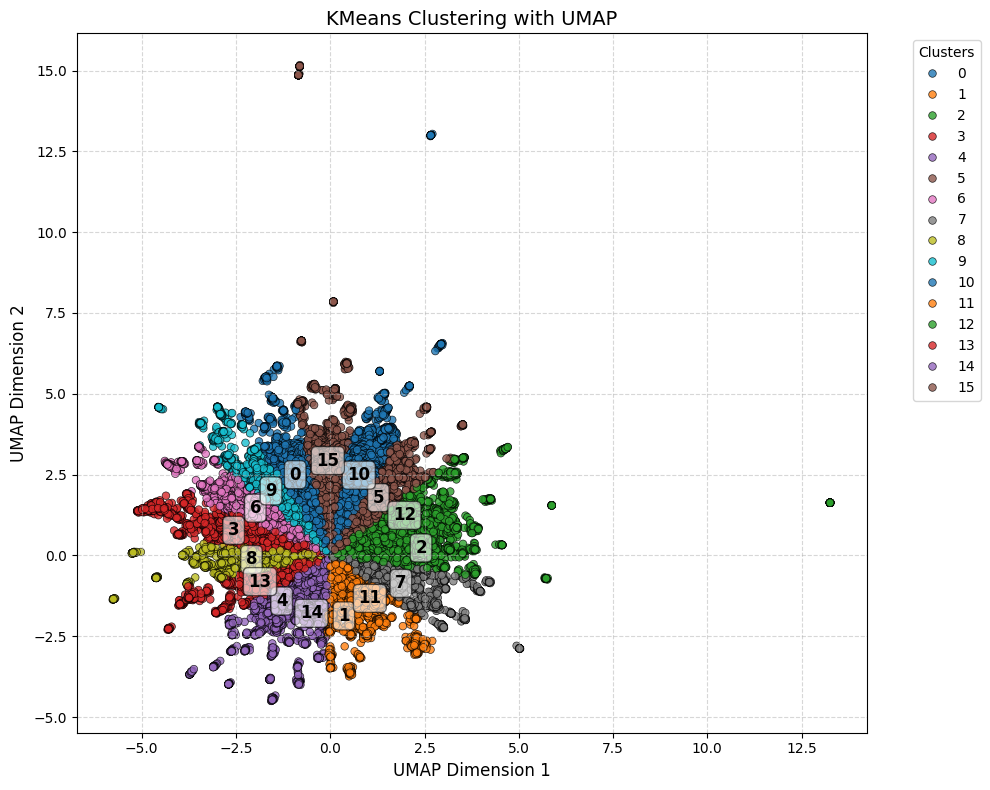

In [23]:
plt.figure(figsize=(10, 8))

scatter = sns.scatterplot(
    x=df['X_umap_0'],
    y=df['X_umap_1'],
    hue=df['cluster_kmeans_16'],
    palette='tab10',
    s=30,
    edgecolor='black',
    linewidth=0.5,
    alpha=0.8
)

# Compute centroids for each cluster
centroids = df.groupby('cluster_kmeans_16')[['X_umap_0', 'X_umap_1']].mean()

# Add labels at cluster centroids
for cluster, (x, y) in centroids.iterrows():
    plt.text(x, y, str(cluster), fontsize=12, fontweight='bold', ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.6, edgecolor='black', boxstyle='round,pad=0.3'))

# Improve labels and layout
plt.title('KMeans Clustering with UMAP', fontsize=14)
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

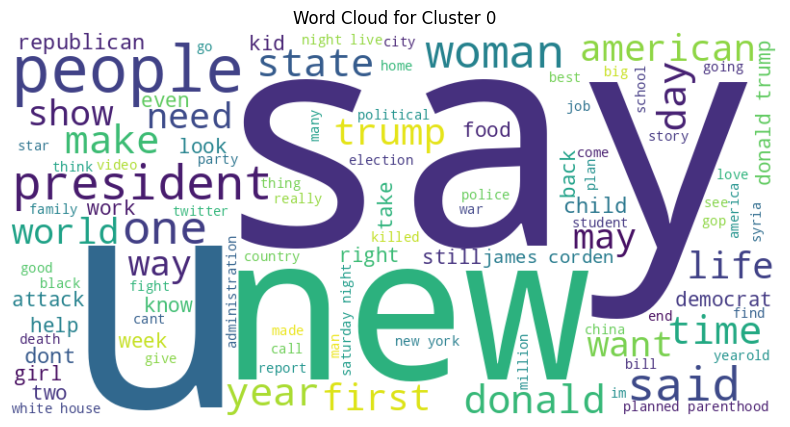

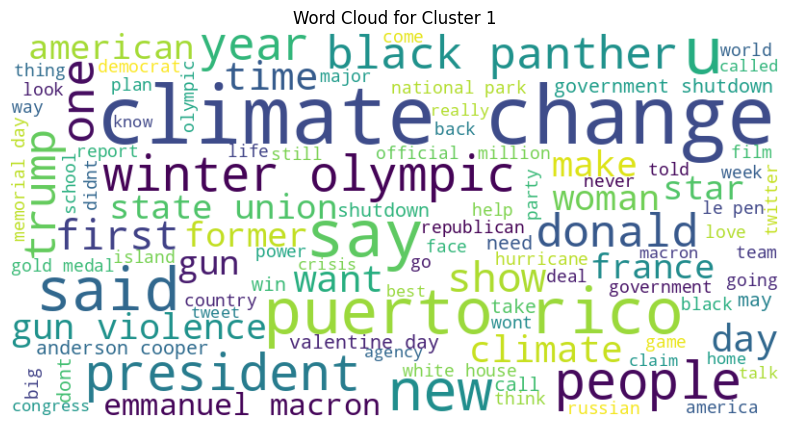

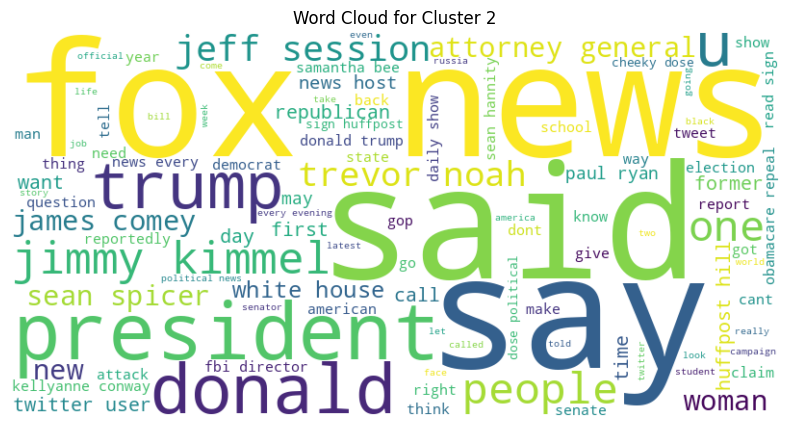

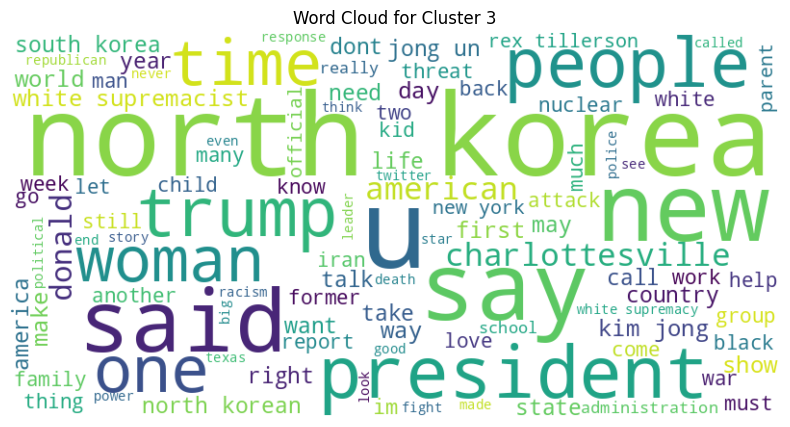

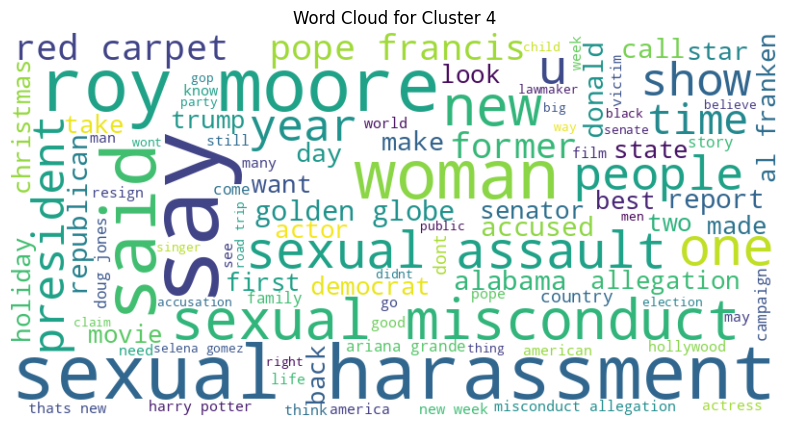

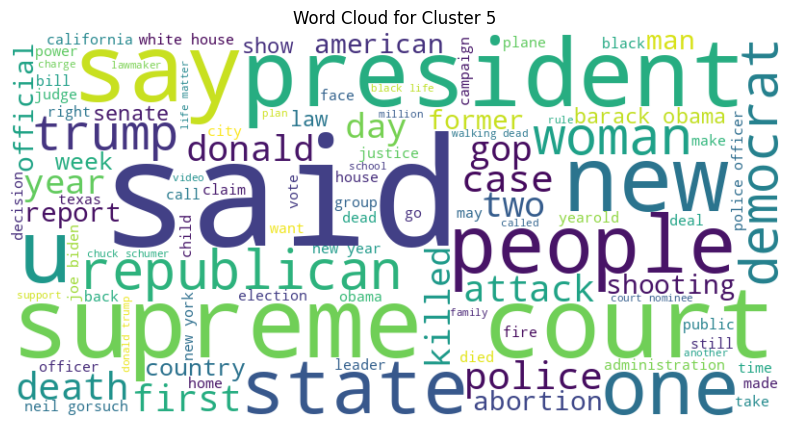

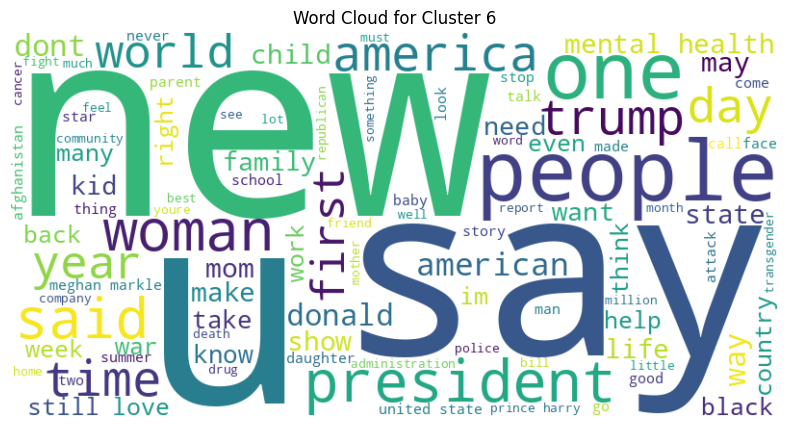

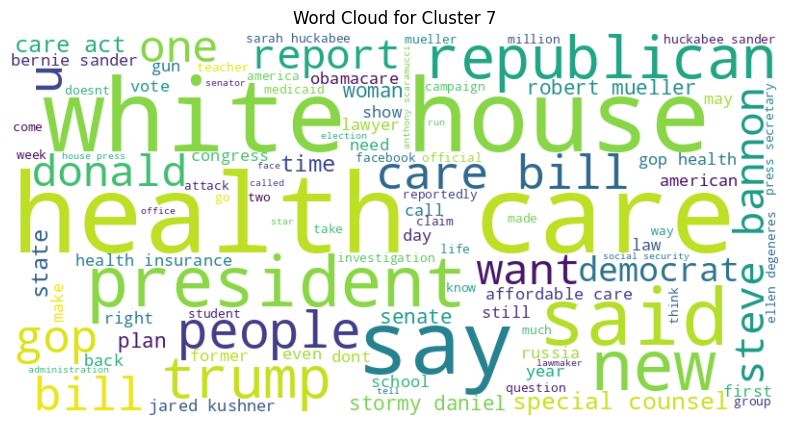

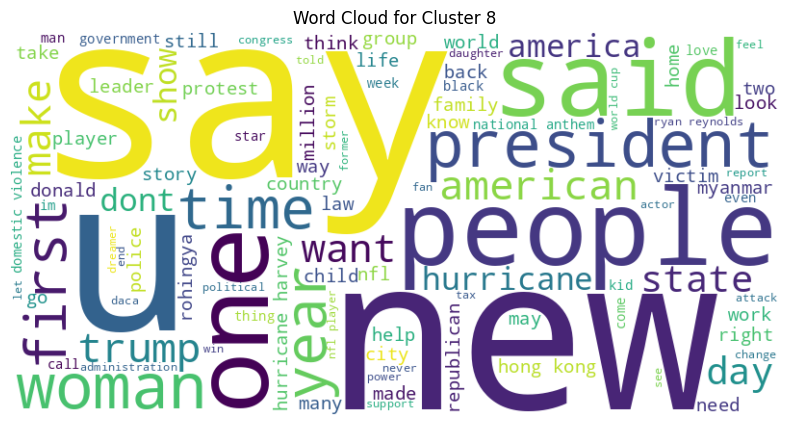

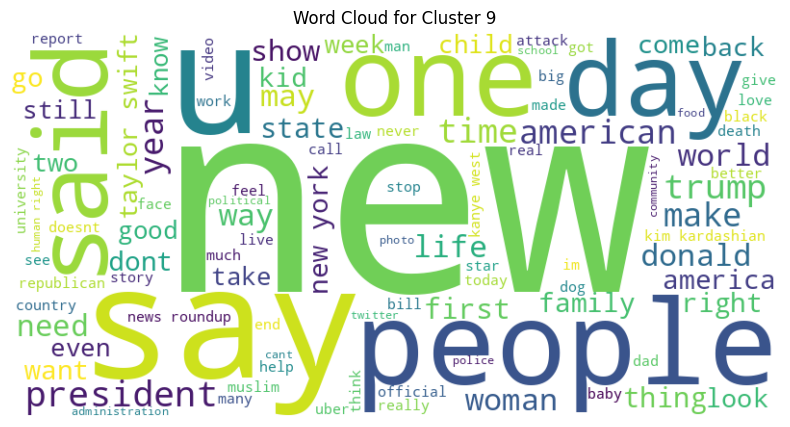

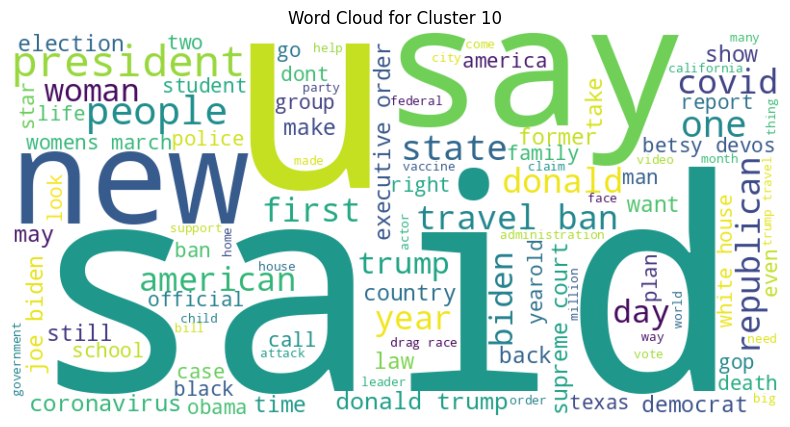

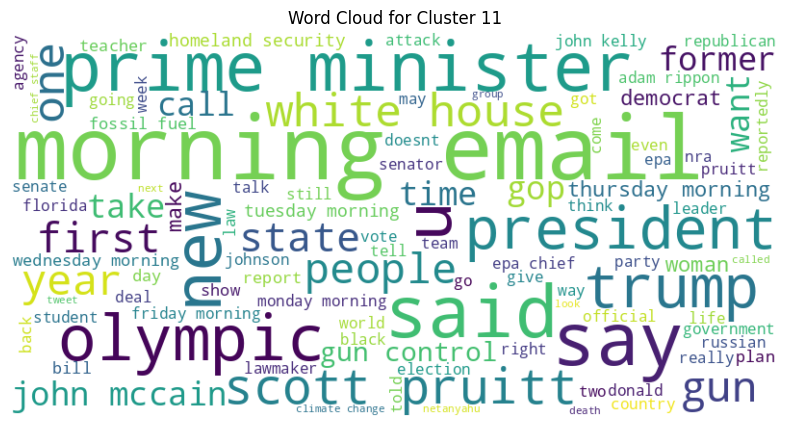

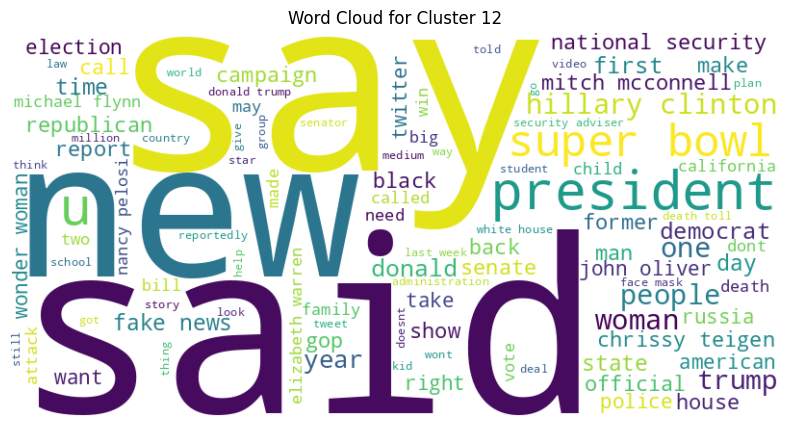

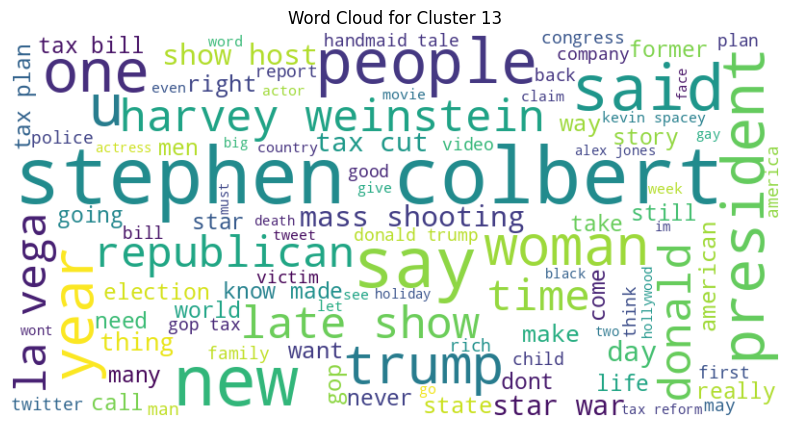

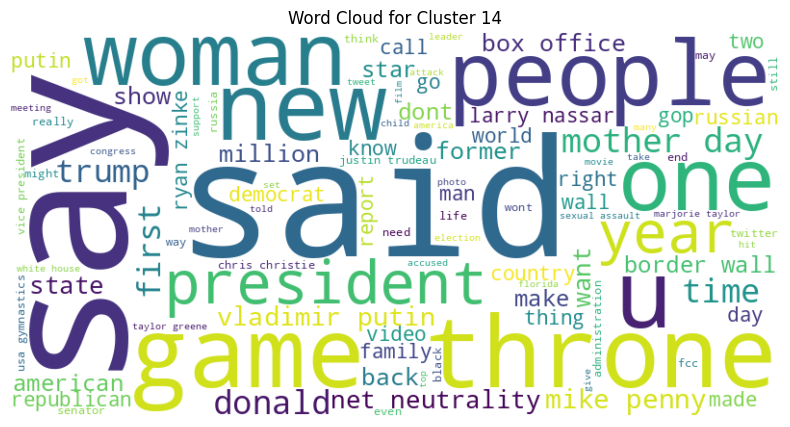

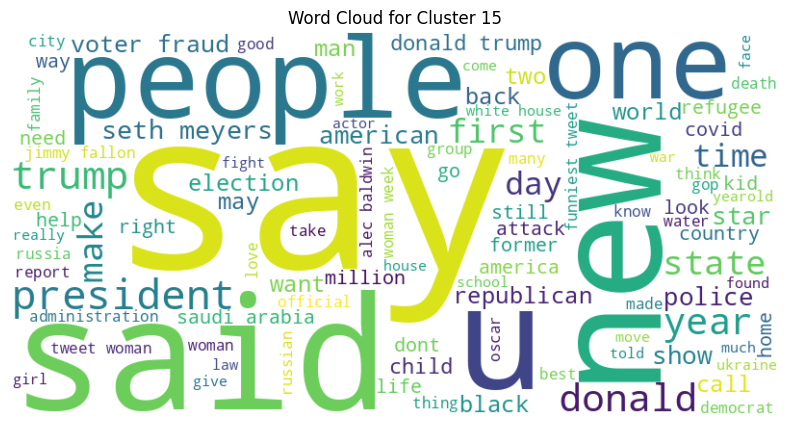

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordcloud(cluster_num, df, vectorizer):
  """Generates and displays a word cloud for a specific cluster."""

  # Filter data for the specific cluster
  cluster_data = df[df['cluster_kmeans_16'] == cluster_num]['filtered_text']

  # Join all text from the cluster
  text = ' '.join(cluster_data.astype(str).tolist())

  # Generate word cloud
  wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)

  # Display word cloud
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.title(f"Word Cloud for Cluster {cluster_num}")
  plt.show()


# Loop through each cluster and generate word cloud
for i in range(16):
    generate_wordcloud(i, df, vectorizer)